In [2]:
from adam import ADAM
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
import numpy as np
from qiskit.quantum_info import Statevector
from math import log

In [2]:
# size of training data set
training_size = 100
# dimension of data sets
n = 4
from sklearn import datasets
from sklearn import preprocessing
iris = datasets.load_iris()
# load iris and normalise
x = preprocessing.normalize(iris.data)
x1_train = x[0:49, :] # class A
x2_train = x[50:99, :] # class B
training_input = {'A':x1_train, 'B':x2_train}
class_labels = ['A', 'B']

In [3]:
sv = Statevector.from_label('0' * n)

In [4]:
def final_circuit(circuit, data, params):
    for i in range(n):
        circuit.h(i)
        circuit.rz(data[i], i)
    
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i, j)
            circuit.rz((np.pi-data[i])*(np.pi-data[j]), j)
            circuit.cx(i, j)
            circuit.barrier()
            
    for i in range(n):
        circuit.ry(params[i],i)
    
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i,j)
    circuit.barrier()
    
    for i in range(n):
        circuit.rz(data[i], i)
    
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i, j)
            circuit.rz((np.pi-data[i])*(np.pi-data[j]), j)
            circuit.cx(i, j)
            circuit.barrier()
            
    for i in range(n):
        circuit.ry(params[i+4],i)
        
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i,j)
    circuit.barrier()
    
    for i in range(n):
        circuit.rz(data[i], i)
    
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i, j)
            circuit.rz((np.pi-data[i])*(np.pi-data[j]), j)
            circuit.cx(i, j)
            circuit.barrier()
            
    for i in range(n):
        circuit.ry(params[i+8],i)
        
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i,j)
    circuit.barrier()
    
    for i in range(n):
        circuit.rz(data[i], i)
    
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i, j)
            circuit.rz((np.pi-data[i])*(np.pi-data[j]), j)
            circuit.cx(i, j)
            circuit.barrier()
            
    for i in range(n):
        circuit.ry(params[i+12],i)
        
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i,j)
    circuit.barrier()
    
    for i in range(n):
        circuit.rz(data[i], i)
    
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i, j)
            circuit.rz((np.pi-data[i])*(np.pi-data[j]), j)
            circuit.cx(i, j)
            circuit.barrier()
            
    for i in range(n):
        circuit.ry(params[i+16],i)

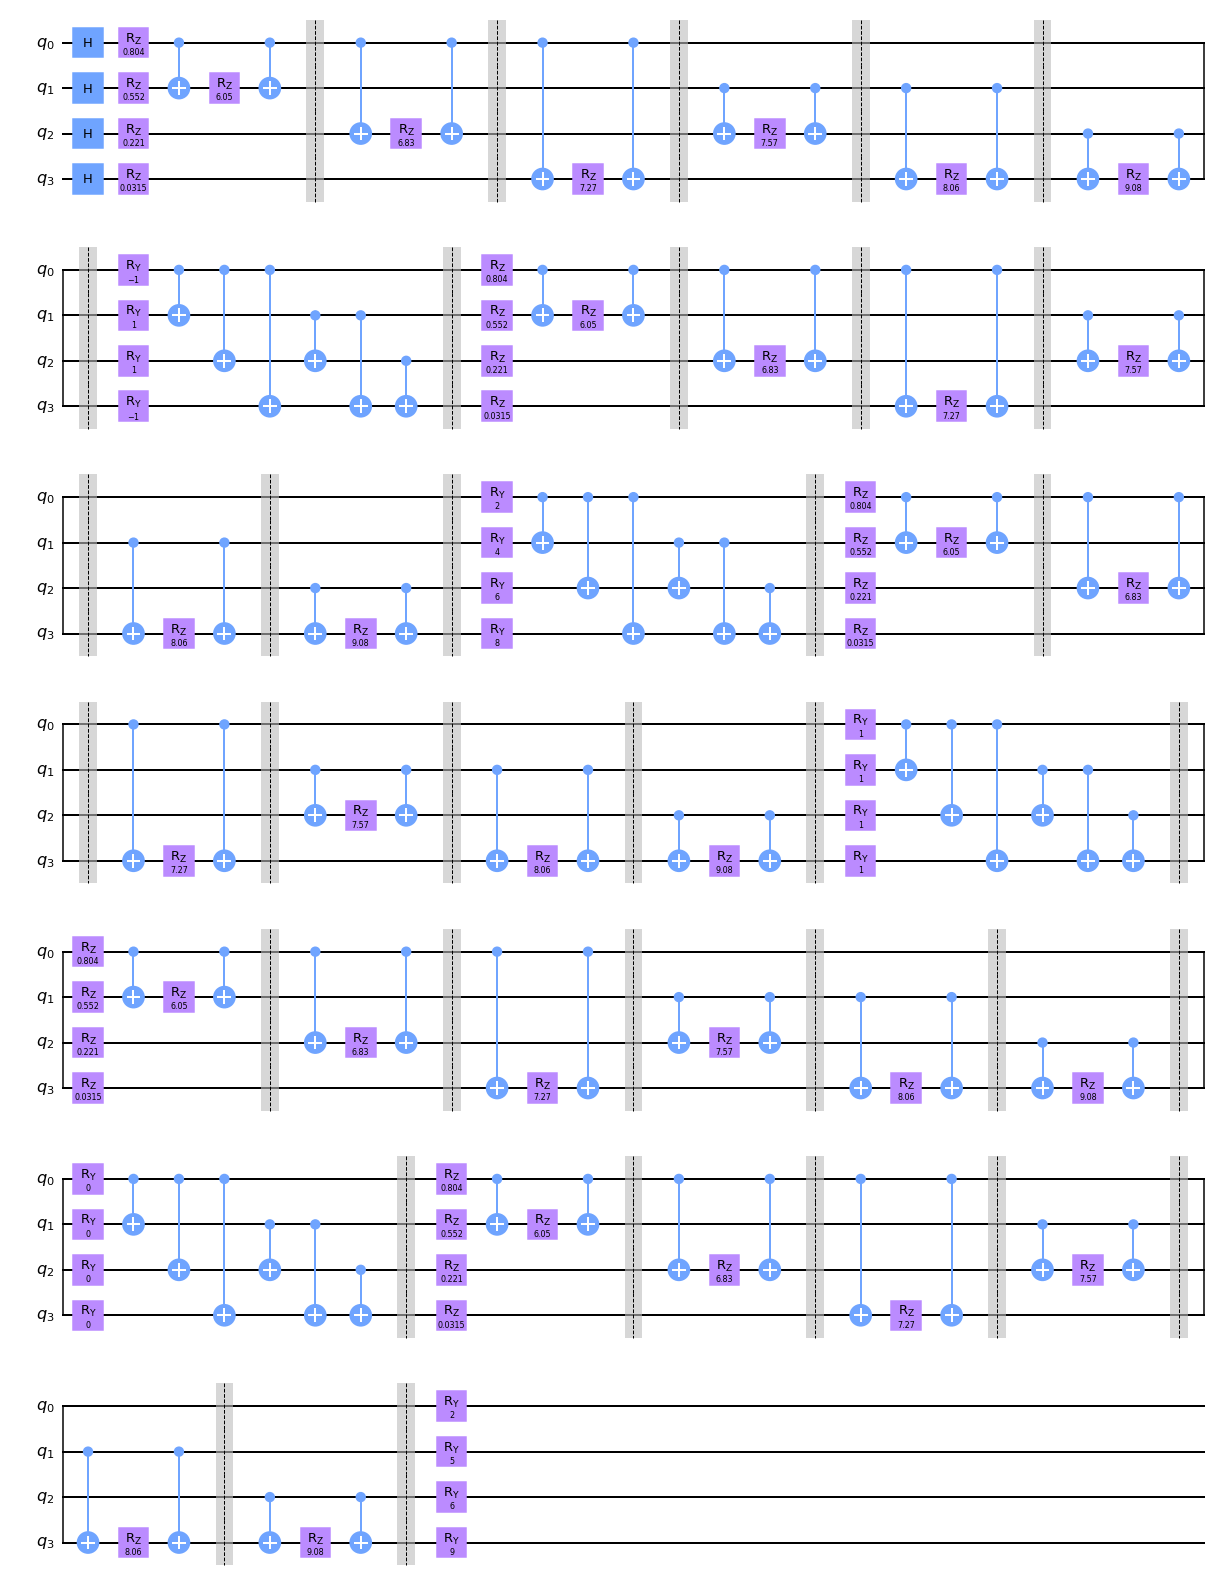

In [5]:
cir = QuantumCircuit(n)
final_circuit(cir, x[0], [-1,1,1,-1,2,4,6,8,1,1,1,1,0,0,0,0,2,5,6,9])
cir.draw('mpl')

In [ ]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circuit = QuantumCircuit(n)
        circ_ = final_circuit(circuit, x, params)
        qc = sv.evolve(circuit)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


def CrossEntropy(yHat, y):
    if y == 'A':
      return -log(yHat['A'])
    else:
      return -log(1-yHat['A'])


def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    # return objective value
    #print(cost)
    return cost


# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.1)

# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)

d = 20   # num of trainable params
for i in range(38,100,1):
    print(i)
    np.random.seed(i)
    # randomly initialize the parameters
    init_params = np.random.uniform(-1,1,d)
    print(init_params)
    # train classifier
    #init_params = np.random.uniform(-1,1,2)
    opt_params, value, _, loss = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
    print(loss)
    print(opt_params)
    # print results
    f1 = 'quantum_loss_hard_layer5_%d.npy' %i
    f2 = 'opt_params_hard_layer5_%d.npy'%i
    np.save(f2, opt_params)
    np.save(f1, loss)

38
[-0.23045376  0.71941569  0.88839927  0.40564979  0.26726819  0.21192256
 -0.59974631 -0.22522422 -0.48203367 -0.85078544 -0.43808605 -0.1231317
 -0.03350191  0.73697897  0.05925877  0.12452629 -0.05788931  0.37768401
  0.00965721  0.64635151]
[0.5218273814381627, 0.4031075650776326, 0.3294027843051976, 0.2911544420132301, 0.2698614547280193, 0.2537479462510011, 0.2379651593849288, 0.220898140803873, 0.20527274679833918, 0.19519944200132736, 0.1910564816377972, 0.18990336191929277, 0.1886808846530219, 0.18585883774986578, 0.18124190717188143, 0.17508835966938083, 0.1677559402366228, 0.15987232699363826, 0.15228871253183357, 0.145730705871068, 0.14046000218194296, 0.13622869312057334, 0.13256328759354, 0.12906965817268287, 0.12549700143993817, 0.12165034997450325, 0.11739978982190527, 0.11285589453748136, 0.10852182669030458, 0.10519387125829523, 0.10355536940433113, 0.10364811101638446, 0.10463540395985954, 0.10520864843436693, 0.10442881460061938, 0.10229760473096555, 0.09963008657

[0.4035536885400932, 0.33484087145794184, 0.28465611642633387, 0.2527332841597169, 0.23203167506055236, 0.21803618557271487, 0.2083462234635042, 0.20037417880874442, 0.19260098243978166, 0.185918363316265, 0.18113999253829785, 0.17729212431386332, 0.1724478649649927, 0.1656341369768394, 0.15748293297988322, 0.14957419891738497, 0.1435104622554535, 0.13995814590287955, 0.1380557637181669, 0.13642075613578183, 0.13469506596349332, 0.13335328951149183, 0.1326294783276159, 0.13196866159608264, 0.13038081416571615, 0.12728737347331365, 0.12287783603472614, 0.11778269740411762, 0.11289251846416533, 0.10933246372296619, 0.10789919309179577, 0.10825469348410321, 0.10892652596253008, 0.10838861154113216, 0.10613668194083394, 0.10273609756983866, 0.09921382074540251, 0.09649872890824847, 0.09493397606436524, 0.09399617298219767, 0.0927105518286417, 0.09051425209048625, 0.08757791434944547, 0.08436512496556348, 0.08119640239151343, 0.0782920088209083, 0.07589373805096904, 0.07412363890124238, 0.0

[0.48737312378348535, 0.4129440924698615, 0.3686352991746557, 0.328815672276198, 0.2864984287784984, 0.24543465043755883, 0.20859761030246812, 0.17994263278075254, 0.1606071873869537, 0.14931463763592664, 0.14571254951760895, 0.1469146482781833, 0.14803984493691014, 0.14598806863515407, 0.13951438016566667, 0.12884320603293065, 0.11556366722141757, 0.10232725313617289, 0.09202710565697128, 0.08660808888286375, 0.08600988604245813, 0.08807555379739186, 0.08997656553383311, 0.09002071156077057, 0.08824827682410377, 0.08573945228630511, 0.08354024627215637, 0.08204231643902103, 0.0810788059648411, 0.08035971154774695, 0.07969957534878983, 0.07891400442261992, 0.07770584615449219, 0.07583689788808237, 0.0734636509365782, 0.0712162428417565, 0.06982714700308394, 0.0695970208791509, 0.07016701569220811, 0.07080421790165776, 0.07094609735048721, 0.07051244006338041, 0.06976777685639618, 0.06899055663606211, 0.06830820470012672, 0.06775349925918395, 0.06735087187504599, 0.06711187975524151, 0.

[0.5008831313886528, 0.3993430945459703, 0.3395852203914801, 0.317918807957111, 0.3074964868397004, 0.28924777397674, 0.26664679394347385, 0.245733610325099, 0.22938205962827346, 0.21934187387127638, 0.21339294510084886, 0.2065532335361065, 0.1959772547128518, 0.18301248557828392, 0.1707151542423186, 0.1610590620728888, 0.15417437773262288, 0.14940091516400902, 0.14636149146855545, 0.1448078394222375, 0.14409687903727925, 0.14308165607411488, 0.1407052630713141, 0.1368078821969861, 0.13226350226420297, 0.12830172072399607, 0.12553734630928134, 0.12361149871695006, 0.12181876638147202, 0.11991583967105826, 0.1182306214013046, 0.11710415365958429, 0.1164049620245598, 0.11570347050446123, 0.11476620090473365, 0.11369213037234413, 0.11261154119228813, 0.11143020350440948, 0.10997937708437176, 0.1083034144295598, 0.10667250041851788, 0.1053178572046328, 0.10419504993543038, 0.10307631599869771, 0.10184256700157145, 0.10054950334307507, 0.09925120479525258, 0.0979091520332369, 0.096499871589

[0.45837162505155615, 0.38040873787330826, 0.3113916193475377, 0.25320687045549545, 0.2149560846749837, 0.19418578806717124, 0.17949303984299486, 0.1664570513667738, 0.1556785261745927, 0.1476366826788835, 0.1421546536022337, 0.1378973800190693, 0.13292069916651694, 0.12747824120623832, 0.12372022656958577, 0.12275648793634493, 0.12240330001669254, 0.11895722230485997, 0.11116997595724137, 0.10120818092005088, 0.09296099736912698, 0.08936777062211251, 0.090380829514154, 0.09351251217274202, 0.09622558487531178, 0.09732534938950645, 0.09672554814788357, 0.09472016570582321, 0.0916580122275186, 0.0881319418356385, 0.0851790719986509, 0.0838545490353482, 0.08430344070926656, 0.08543351215742132, 0.0858582727799318, 0.08507079552074431, 0.08357339297545716, 0.08215822605708402, 0.08124204608174766, 0.0807703329224058, 0.080544919367252, 0.08049259662259836, 0.08063353433476378, 0.080919104227634, 0.08118613622913533, 0.08126610887405362, 0.08110478132870187, 0.08076656990831466, 0.08035780

[0.4355891688429561, 0.3534362144481577, 0.2828015355279611, 0.22398837976762126, 0.18333065250090846, 0.15789041217733882, 0.14295375215567066, 0.13526770906498478, 0.13406599479007505, 0.13838485596793426, 0.1440821298891934, 0.14621991382721566, 0.14345924500874607, 0.1377832083882713, 0.13184427046753958, 0.1271272277127035, 0.12357405163230571, 0.1204163106580142, 0.11718212582172943, 0.11391977277114725, 0.1109357884319701, 0.10856105248184822, 0.10694694102679013, 0.10591993842859773, 0.10506740969333299, 0.1039825180898931, 0.1024702202398081, 0.10063325027026114, 0.09880858722453498, 0.09738011822202129, 0.09657246448924271, 0.09634136041956, 0.09642092050889917, 0.0964880674387363, 0.09632113479995756, 0.09585377464684412, 0.09513080691673058, 0.09424293462568928, 0.0932955240906002, 0.09240301818719558, 0.09167442048390098, 0.09118461125088313, 0.09095404012694093, 0.09094524884621542, 0.09106827675639788, 0.0912009396151306, 0.09123322150869513, 0.09111348439144551, 0.09085

[0.7757931294789923, 0.6590145247894076, 0.5648255388601985, 0.48134403785782237, 0.4140709623121871, 0.36249246279606046, 0.32490393462933465, 0.30077858161286014, 0.2877104270234414, 0.28101477789734475, 0.27636783860778225, 0.2713933183471276, 0.26449854409153445, 0.25385780698850585, 0.23854295695034328, 0.2200434412238497, 0.20206906032059244, 0.1886790253515993, 0.18181719458876341, 0.17959622134419512, 0.17763576384095836, 0.17304990259141712, 0.1658350789050377, 0.15722930375634864, 0.14833062155749713, 0.13985908091004734, 0.13229560898779663, 0.12590410899468876, 0.12070497969618273, 0.1165278469648342, 0.11310951333941234, 0.11017343268936913, 0.10749672210088704, 0.10495729182306249, 0.10252920568413562, 0.10023718225338747, 0.09809202493550587, 0.09602403507770448, 0.09387347597285256, 0.0914894468543231, 0.08887240029366764, 0.08621583221827417, 0.08378351482703868, 0.08171816627665264, 0.07995556874412188, 0.07832958672931101, 0.0767642920268012, 0.07535849983004961, 0.0

[0.5043711974390795, 0.39314639526906403, 0.3212507296528961, 0.27765707074345375, 0.24832941016014884, 0.22724142401657615, 0.2141471581724951, 0.20670142870610644, 0.19667195682103455, 0.18235935951196963, 0.1677170247737949, 0.1561663875004358, 0.1474051549798537, 0.13921337498409292, 0.13016989201378207, 0.11976553839343193, 0.10861645898875472, 0.09844619045897592, 0.09118169484725638, 0.08801193794237368, 0.08869750764188641, 0.09160361358837038, 0.09452126784877546, 0.0956797403158048, 0.09437147477503267, 0.09094999986796913, 0.08636277084616928, 0.08165252067656575, 0.07763982330993248, 0.07475011181379955, 0.07294464688260198, 0.07178789322778736, 0.07068735787839174, 0.06922608254838018, 0.06739449886270871, 0.06556148692163047, 0.0641992848911138, 0.06356461678018903, 0.06355815263747042, 0.06382658095113804, 0.0639897035699283, 0.0638162231338252, 0.06326683734615995, 0.06245553366118416, 0.061597350508907744, 0.06093365910052897, 0.060618812361264734, 0.06062654542910149,

[0.5162451057362014, 0.4376209111562758, 0.37943087882083515, 0.3312294233379262, 0.2848153814043358, 0.24390324529618193, 0.21526926039676317, 0.1991296391581322, 0.18907915294426206, 0.17916685689571735, 0.17040358319627366, 0.16654477915298582, 0.16821463524521532, 0.1722664327919878, 0.1740602384434882, 0.17025639879112736, 0.16066294606361592, 0.14791365454500527, 0.13567633592707612, 0.12672840504805447, 0.12219168086142287, 0.12172876244589148, 0.12382265709225601, 0.12644056415023283, 0.12802217613960704, 0.12792180546582602, 0.12612366468701378, 0.1227454764325727, 0.11802491937899355, 0.11273396710150821, 0.10804458710420234, 0.10491560035861082, 0.10362070465555762, 0.10366687376281049, 0.10406337166388388, 0.10383054526640934, 0.10252330899043369, 0.10042260118244128, 0.09821253548636223, 0.0964082207399814, 0.0950750220176976, 0.09407045277233497, 0.09335158818411306, 0.09293094308533895, 0.09267651727071005, 0.0922984645913321, 0.0915599993028853, 0.0904881076402785, 0.08

[ 0.01917466  0.64690367  0.3570563  -0.0047724  -0.58470008 -1.09113071
 -1.09132666 -0.52615003  0.34417341 -0.33874578 -1.25682551  0.72782512
 -0.87433073 -0.25071996 -1.28771042  0.30733    -0.4125326   0.78949833
  0.30974837 -1.30967913]
74
[-0.59559541  0.56909521  0.72107448 -0.3458296  -0.50227905  0.62072743
  0.42686958  0.32265683  0.42098251 -0.77419825  0.73994401 -0.04714437
 -0.83945824 -0.70245908 -0.35195149 -0.98648523  0.43376015 -0.86984656
 -0.15230852  0.60975918]
[0.4850758722923776, 0.3936685352319467, 0.3500288547671157, 0.3219660678139464, 0.29426749656115503, 0.2677913202904821, 0.24579626130654014, 0.22849416008271334, 0.21474819786617702, 0.20350091848148963, 0.1939922043568574, 0.185752946334159, 0.17802707008650986, 0.16940257953251003, 0.15933326993330468, 0.14934342279638627, 0.142113664803638, 0.13933953082437311, 0.14011401636568152, 0.14160601102469023, 0.14132959132250128, 0.13843471526795156, 0.13328900776809066, 0.1265960606175878, 0.11909087227

[0.657948153641524, 0.5335189779500323, 0.4665127608256607, 0.4152746770111569, 0.35626735091728917, 0.29652165594736396, 0.25280804709628396, 0.23276179350545478, 0.2260259094443113, 0.2169598192864289, 0.2006466240877876, 0.18012332115124924, 0.1603281851711261, 0.14419293396105898, 0.13170603632351693, 0.121541838037699, 0.11243364404761738, 0.10373184274886581, 0.09564602182135615, 0.08898723951715884, 0.08432508079683433, 0.08119811435142145, 0.07834793884513533, 0.07470895795770184, 0.07006174489685958, 0.06504864150112104, 0.060750615164617605, 0.05806869919098461, 0.057202444131258, 0.05752255664856942, 0.05796146881202781, 0.05766736013731295, 0.056437610926943695, 0.054665641702262846, 0.05293364714747891, 0.05158917723461259, 0.05057801366291593, 0.049592320601178394, 0.04837587022412259, 0.04693974957588715, 0.045549343765842056, 0.044530658923281265, 0.044049451920548655, 0.04401327469610153, 0.04415435837570832, 0.044215798071824346, 0.044094402189117574, 0.04385083592251

[0.4195319271756811, 0.35477492571497055, 0.29646594204001975, 0.2450523995742351, 0.20662060704692545, 0.183146732353491, 0.17316075163009473, 0.1718856289941268, 0.17479037602146705, 0.1770341037867904, 0.17648718066282348, 0.17371996558854202, 0.16919029125431975, 0.16341393658217326, 0.15733899025673673, 0.15161803826797987, 0.14629683013146164, 0.14093923752042453, 0.13512221325704096, 0.12934801278075408, 0.12483699410583446, 0.12210720660735033, 0.12016554070598817, 0.11741838007694928, 0.11329424660007584, 0.1085250645559999, 0.10410455216084558, 0.1003804608185161, 0.0972033972639074, 0.09457823928497434, 0.09276718052993536, 0.0918958859240118, 0.09168094032639057, 0.0916343660579252, 0.09151511088939236, 0.09143104540408314, 0.09149005939059153, 0.09151022629680283, 0.0911436061547567, 0.09021979950257382, 0.08887730067807122, 0.0873724759043777, 0.08586321248090345, 0.0843784821731821, 0.08290046270956204, 0.08142677775419017, 0.07997996873430994, 0.07859162000472197, 0.077

[0.491784360126231, 0.3890364930975027, 0.33171170989766646, 0.2947850299731124, 0.26395288988319626, 0.24128048956015938, 0.22644158598367892, 0.2146694640715564, 0.20142031990394407, 0.18548261211167208, 0.16960390530027414, 0.15686826981121257, 0.14762313492862061, 0.13989360949103088, 0.1320156418520819, 0.12377973386939593, 0.11564513545705822, 0.10794502288906477, 0.10099528294816283, 0.09554062544234584, 0.09258466689372416, 0.09243600119133467, 0.0939554030803566, 0.09515241051545831, 0.09458706750832449, 0.09205102890387085, 0.08820367594025283, 0.08385389429590884, 0.07953944304617072, 0.07555638436046419, 0.07213262261942224, 0.06940558060197718, 0.06725800752795391, 0.06534490364720724, 0.06338516191671349, 0.0613746610900599, 0.05947090325897084, 0.05773750754213734, 0.056083477932183434, 0.05444584548291427, 0.05293885227842857, 0.05177180371973907, 0.05106014392068631, 0.05074992160567626, 0.05069369405487555, 0.05074120911252523, 0.05074903160979132, 0.05057222400045687

[0.5594191858790053, 0.45337335167707166, 0.36743843945184296, 0.2936139580649749, 0.2401294903950378, 0.21230522759320594, 0.20115585616218784, 0.1928774846253639, 0.18207181107814904, 0.1712444774030395, 0.1619641016175811, 0.15294914405121346, 0.1442908142028417, 0.13660874012819635, 0.1293282031313166, 0.12206817811871112, 0.1153556152251764, 0.10934078898389446, 0.10352038316065895, 0.09772528359271443, 0.09247473105753315, 0.08854407458120914, 0.08646870215722369, 0.08618047291935131, 0.0869276539693867, 0.08760159770216128, 0.08728147488563208, 0.08561369489780733, 0.08279551612780385, 0.07928417377642111, 0.07554397566116197, 0.07199162729043503, 0.06903107342836978, 0.06699772830434816, 0.06598575212095838, 0.06571575696406023, 0.06562773455860488, 0.06520064967836235, 0.06425844393693347, 0.06300822568485809, 0.06180459903689802, 0.06085497999322084, 0.060088212581095514, 0.05925549781531814, 0.058151482495551486, 0.05676946008834494, 0.05529024630197098, 0.0539516982640282, 

93
[ 0.21270868  0.31502314 -0.38551798  0.92400697  0.07183781  0.31926938
  0.99875306  0.50196785  0.07704441  0.49101091 -0.52880361 -0.16729902
  0.69003951 -0.18870651 -0.05088291  0.38635837 -0.62967326 -0.86345029
  0.24458401  0.20203674]
[0.5152294450894616, 0.4593978153880146, 0.4120999062425198, 0.3665866356724415, 0.3252191617630283, 0.282374816474115, 0.2379082908402397, 0.20290255501631776, 0.18359721697049786, 0.17100728014520947, 0.15561168247746768, 0.13860892411091633, 0.1258591389052922, 0.12103489361499768, 0.12258008180621822, 0.12559840920906143, 0.12551216401171475, 0.12045116523636472, 0.11137895429619526, 0.10071631674218331, 0.0908403783452832, 0.08302713910795678, 0.07730465997040799, 0.0732746115472152, 0.07064705689476725, 0.06901324504330417, 0.06769084065471431, 0.06611677150856109, 0.06429069345432306, 0.06268910810985227, 0.06183611687270277, 0.06193149956266592, 0.06270677450033549, 0.06353983641718278, 0.06377004357040494, 0.06303889450693735, 0.0614

In [4]:
loss_eqnn_d1 = np.load('Data/5Layers/Layer5Hard4q/quantum_loss_hard_layer5_1.npy')

In [5]:
loss_eqnn_d1.shape

(100,)

In [13]:
#loss = np.zeros((100,100))
loss = np.zeros((96,100))
for i in range(96):
    file = 'Data/5Layers/Layer5Hard4q/quantum_loss_hard_layer5_%d.npy'%i
    loss[i] += np.load(file, allow_pickle=True)

In [15]:
loss

array([[0.29536205, 0.23684678, 0.21994651, ..., 0.05053289, 0.05041675,
        0.05033116],
       [0.5613679 , 0.49840596, 0.44979817, ..., 0.04515216, 0.04515211,
        0.0451523 ],
       [0.54203325, 0.39495724, 0.32546345, ..., 0.07067045, 0.07059656,
        0.07053837],
       ...,
       [0.51522945, 0.45939782, 0.41209991, ..., 0.05028596, 0.0499006 ,
        0.04947201],
       [0.58220818, 0.44656285, 0.36256943, ..., 0.06462581, 0.06460304,
        0.0645656 ],
       [0.49143966, 0.37421707, 0.31759406, ..., 0.04157111, 0.04152157,
        0.04147206]])

Text(0.5, 1.0, 'Training - 5 Layer (Data Reuploading, Qubits = 4, Hard Model)')

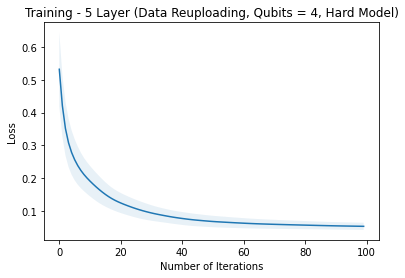

In [16]:
import matplotlib.pyplot as plt
groen = np.array([0,208,0])/255
stddevs =[]
averages =[]
sd = np.std(loss, axis=0)
av = np.average(loss, axis=0)
plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)
stddevs.append(sd)
averages.append(av)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 5 Layer (Data Reuploading, Qubits = 4, Hard Model)")

In [18]:
losseasy = np.zeros((100,100))
for i in range(100):
    file = 'Data/5Layers/Layer5Easy4q/quantum_loss_easy_layer54q_%d.npy'%i
    losseasy[i] += np.load(file, allow_pickle=True)

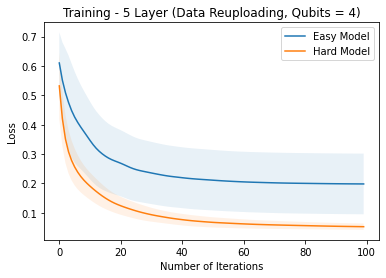

In [19]:
stddevs =[]
averages =[]
sde = np.std(losseasy, axis=0)
ave = np.average(losseasy, axis=0)
plt.plot(range(100), ave)
plt.fill_between(range(100), ave+np.array(sde), ave-np.array(sde), alpha=0.1)
stddevs.append(sde)
averages.append(ave)

plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 5 Layer (Data Reuploading, Qubits = 4)")

legendList = ['{}'.format(i) for i in ["Easy Model", "Hard Model"]]
plt.legend(legendList)